# Shallow Learning Model 1 - Logistic Regression 

# Workspace Setup

In [0]:
# Data loading and manipulation
import pandas as pd
import numpy as np

# Matplotlib for general plotting
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')

# Seaborn for distribution plots
from seaborn import distplot

# Scikit imports
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc, confusion_matrix 
from seaborn import light_palette

# Functions


## Function 1 - Classification Results

 Uses a classification report, a receiver-operating characteristics curve with its area, and the confusion matrix to summarise classification performance of a model.

In [0]:
def get_classification_result(y_pred, y_true, classifier_name=None):
    """Custom function to display classification results"""
    # Display the classification report 
    print("CLASSIFICATION REPORT")
    print(classification_report(y_true, y_pred, labels=[0, 1], 
                                target_names=['Regular Consumer', 'Thieves']))
    
    # Display the confusion matrix
    print("CONFUSION MATRIX")
    conf_mat = pd.DataFrame(data=confusion_matrix(y_true, y_pred))
    conf_mat.index = ['True 0', 'True 1']
    conf_mat.columns = ['Predicted 0', 'Predicted 1']
    cm = light_palette('blue', as_cmap=True)
    conf_mat_display = conf_mat.style.background_gradient(cmap=cm)
    display(conf_mat_display)
    
    # Display ROC 
    fpr, tpr, _ = roc_curve(y_true, y_pred, pos_label=1)
    roc_auc = auc(fpr, tpr) 
    plt.figure(figsize=(5, 5))
    plt.plot(fpr, tpr, lw=2, label='ROC Curve (area = %0.2f)' % roc_auc)
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.legend(loc='lower right')
    
    if classifier_name is not None:
        plt.title(f'ROC Curve - {classifier_name}', fontsize=14)

# Importing Data

In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [0]:
filepath = '/content/drive/My Drive/EE 16-17 FYP DL Energy Theft Detection/Data/full-processing-data/final-scaled-data.csv'

In [0]:
data = pd.read_csv(filepath)

In [0]:
data.head()

,CONS_NO,FLAG,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,2014-01-09,2014-01-10,2014-01-11,2014-01-12,2014-01-13,2014-01-14,2014-01-15,2014-01-16,2014-01-17,2014-01-18,2014-01-19,2014-01-20,2014-01-21,2014-01-22,2014-01-23,2014-01-24,2014-01-25,2014-01-26,2014-01-27,2014-01-28,2014-01-29,2014-01-30,2014-01-31,2014-02-01,2014-02-02,2014-02-03,2014-02-04,2014-02-05,2014-02-06,2014-02-07,...,2016-09-22,2016-09-23,2016-09-24,2016-09-25,2016-09-26,2016-09-27,2016-09-28,2016-09-29,2016-09-30,2016-10-01,2016-10-02,2016-10-03,2016-10-04,2016-10-05,2016-10-06,2016-10-07,2016-10-08,2016-10-09,2016-10-10,2016-10-11,2016-10-12,2016-10-13,2016-10-14,2016-10-15,2016-10-16,2016-10-17,2016-10-18,2016-10-19,2016-10-20,2016-10-21,2016-10-22,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
0,0387DD8A07E07FDA6271170F86AD9151,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0000,...,0.315047,0.385712,0.301797,0.461161,0.290756,0.315783,0.372462,0.366573,0.279715,0.669475,0.402274,0.419940,0.733147,0.393809,0.338602,0.249167,0.248799,0.226348,0.239230,0.297381,0.293332,0.324248,0.271249,0.431349,0.405586,0.301061,0.269777,0.246958,0.313575,0.232237,0.264257,0.297013,0.297749,0.350747,0.201689,0.322040,0.342282,0.277506,0.337130,0.248063
1,01D6177B5D4FFE0CABA9EF17DAFC2B84,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,4B75AC4F2D8434CFF62DB64D0BB43103,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.618551,1.000000,1.000000,1.000000,1.000000,0.944143,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.812126,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
3,B32AC8CC6D5D805AC053557AB05F5343,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0000,...,0.619902,0.607360,0.295618,0.815547,0.504163,0.741732,0.232911,0.357966,0.666126,0.601627,0.961027,0.526737,0.575111,0.863563,0.452922,0.388782,0.421748,0.466897,0.439306,0.561137,0.481230,0.538562,0.523512,0.500580,0.539995,0.505596,0.529246,0.419957,0.420315,0.429273,0.459014,0.541787,0.618469,0.534262,0.701958,0.744957,0.643193,0.690133,0.518138,0.419957
4,EDFC78B07BA2908B3395C4EB2304665E,1,0.144169,0.280383,0.347496,0.165048,0.179465,0.265966,0.235144,0.182945,0.175488,0.17002,0.189408,0.227687,0.176979,0.211282,0.1918

## Train-Test Split

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
# Extracting features and labels
X = data.iloc[:, 2:]
y = data.iloc[:, 1]

In [0]:
# Stratified random sampling of training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=y)

In [0]:
# Confirm one-one correspondence between train and test features and labels
assert len(X_train) == len(y_train)
assert len(X_test) == len(y_test)

### Confirming Stratification in Train/Test Data

In [0]:
from seaborn import barplot

In [0]:
# Dictionaries of raw counts of class labels
raw_counts = {
    'train': {
        '0': np.count_nonzero(y_train == 0),
        '1': np.count_nonzero(y_train == 1)
    }, 
    'test': {
        '0': np.count_nonzero(y_test == 0),
        '1': np.count_nonzero(y_test == 1)
    }
}

In [0]:
# Repeat for normalized counts
NUM_TRAIN = len(y_train)
NUM_TEST = len(y_test)
NUM_SAMPLES = len(y)

normed_counts = {
    'train': {
        '0': np.count_nonzero(y_train == 0) / NUM_TRAIN,
        '1': np.count_nonzero(y_train == 1) / NUM_TRAIN
    }, 
    'test': {
        '0': np.count_nonzero(y_test == 0) / NUM_TEST,
        '1': np.count_nonzero(y_test == 1) / NUM_TEST
    }
}

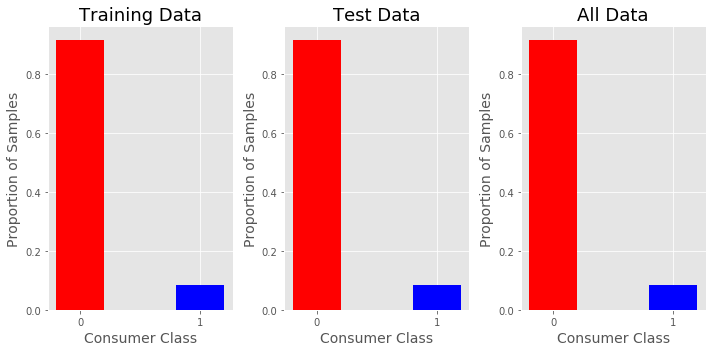

In [0]:
# Comparing train, test, and original data in 3 side-by-side graphs
fig, axes = plt.subplots(ncols=3, figsize=(10, 5), sharey=False)

# First plot - Training Data
plt.sca(axes[0])
plt.bar(x=normed_counts['train'].keys(), height=normed_counts['train'].values(), 
       color=['red', 'blue'], width=0.4)
plt.xlabel('Consumer Class', fontsize=14)
plt.ylabel('Proportion of Samples', fontsize=14)
plt.title('Training Data', fontsize=18)

# Second plot - Test Data
plt.sca(axes[1])
plt.xlabel('Consumer Class', fontsize=14)
plt.bar(x=normed_counts['test'].keys(), height=normed_counts['test'].values(), 
       color=['red', 'blue'], width=0.4)
plt.ylabel('Proportion of Samples', fontsize=14)
plt.title('Test Data', fontsize=18)


# Third plot - All data
plt.sca(axes[2])
plt.xlabel('Consumer Class', fontsize=14)
plt.bar(x=normed_counts['test'].keys(), 
       height=[np.count_nonzero(y == 0) / NUM_SAMPLES, 
               np.count_nonzero(y == 1) / NUM_SAMPLES], 
       color=['red', 'blue'], width=0.4)
plt.ylabel('Proportion of Samples', fontsize=14)
plt.title('All Data', fontsize=18)
plt.tight_layout()

## Training Zheng's Logistic Regression Model

Zheng's model specifies L2 regularization with inverse regularization strength of 1.0. 

In [0]:
from sklearn.linear_model import LogisticRegression

In [0]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_validate, learning_curve
from sklearn.metrics import make_scorer, log_loss

In [0]:
# Instantiate a logistic regression model with the specified hyperparameters
logRegZheng = LogisticRegression(penalty='l2', C=1.0, solver='liblinear', max_iter=500)

In [0]:
# Instantiate a stratified K-Fold Cross Validator for the logRegModel
logRegZhengScores = cross_validate(estimator=logRegZheng, 
                                X=X_train, 
                                y=y_train, 
                                scoring={
                                    'crossentropy': make_scorer(log_loss, 
                                                                        greater_is_better=False)},
                                cv=5,
                                verbose=1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.1min finished


## Exploring `logRegZhengScores`

In [0]:
logRegZhengScores

{'fit_time': array([13.48895359, 14.2967875 , 13.0990696 , 12.99762869, 12.32348871]),
 'score_time': array([0.01422167, 0.01346803, 0.01353931, 0.01360631, 0.01382351]),
 'test_crossentropy': array([-3.04125202, -3.05653514, -3.05698684, -3.03660568, -3.0315106 ])}

## Working with SGDClassifier

In [0]:
from sklearn.linear_model import SGDClassifier

In [0]:
sgdZheng = SGDClassifier(loss='log', 
                         penalty='l2', 
                         shuffle=True, 
                         random_state=0, 
                         learning_rate='adaptive',
                         eta0=0.01,
                         validation_fraction=0.2, 
                         alpha=1)

In [0]:
# Instantiate a stratified K-Fold Cross Validator for the logRegModel
logRegZhengScores = cross_validate(estimator=logRegZheng, 
                                X=X_train, 
                                y=y_train, 
                                scoring={
                                    'crossentropy': make_scorer(log_loss)},
                                cv=5,
                                verbose=1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.1min finished


In [0]:
logRegZhengScores

{'fit_time': array([13.37964606, 14.37420011, 13.19492412, 13.05697846, 12.27574515]),
 'score_time': array([0.01402283, 0.01401973, 0.01424789, 0.01390743, 0.01454592]),
 'test_crossentropy': array([3.04125202, 3.05653514, 3.05698684, 3.03660568, 3.0315106 ])}

In [0]:
logRegTest = LogisticRegression(penalty='l2', C=1.0, max_iter=500, 
                                verbose=2, solver='liblinear')

In [0]:
logRegTest.fit(X_train, y_train)

[LibLinear]

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=2,
                   warm_start=False)

CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.92      0.99      0.95      7752
         Thieves       0.44      0.06      0.10       723

        accuracy                           0.91      8475
       macro avg       0.68      0.52      0.53      8475
    weighted avg       0.88      0.91      0.88      8475

CONFUSION MATRIX


,Predicted 0,Predicted 1
True 0,7701,51
True 1,683,40


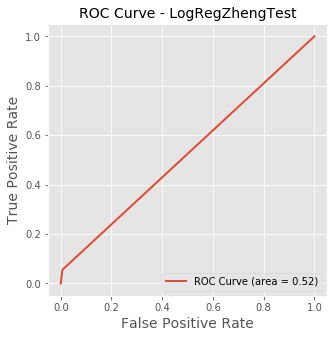

In [0]:
get_classification_result(logRegTest.predict(X_test), 
                          y_true=y_test, classifier_name='LogRegZhengTest')

In [0]:
sgdClassifier = SGDClassifier(loss='log', penalty='l2')

In [0]:
sgdClassifier.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.92      0.99      0.95      7752
         Thieves       0.40      0.08      0.14       723

        accuracy                           0.91      8475
       macro avg       0.66      0.54      0.54      8475
    weighted avg       0.88      0.91      0.88      8475

CONFUSION MATRIX


,Predicted 0,Predicted 1
True 0,7665,87
True 1,664,59


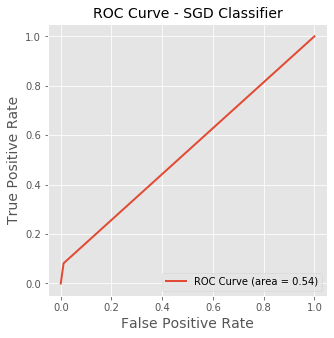

In [0]:
get_classification_result(sgdClassifier.predict(X_test), y_test, classifier_name='SGD Classifier')

## Grid Search Cross Validation

In [0]:
from sklearn.linear_model import LogisticRegressionCV

In [0]:
logRegCV = LogisticRegressionCV(max_iter=500, solver='liblinear', 
                                scoring='roc_auc', cv=5, 
                                Cs=[0.01, 0.03, 0.1, 0.3, 1, 3], 
                                verbose=2)

In [0]:
logRegCV.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.0min remaining:    0.0s


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.7min finished


[LibLinear]

LogisticRegressionCV(Cs=[0.01, 0.03, 0.1, 0.3, 1, 3], class_weight=None, cv=5,
                     dual=False, fit_intercept=True, intercept_scaling=1.0,
                     l1_ratios=None, max_iter=500, multi_class='auto',
                     n_jobs=None, penalty='l2', random_state=None, refit=True,
                     scoring='roc_auc', solver='liblinear', tol=0.0001,
                     verbose=2)

CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.92      1.00      0.96      7752
         Thieves       0.61      0.04      0.07       723

        accuracy                           0.92      8475
       macro avg       0.77      0.52      0.51      8475
    weighted avg       0.89      0.92      0.88      8475

CONFUSION MATRIX


,Predicted 0,Predicted 1
True 0,7735,17
True 1,696,27


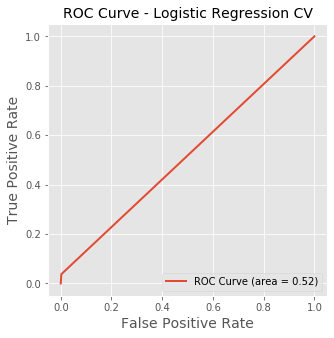

In [0]:
get_classification_result(logRegCV.predict(X_test), y_test, classifier_name='Logistic Regression CV')

## Without Shuffling

In [0]:
data.head()

,CONS_NO,FLAG,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,2014-01-09,2014-01-10,2014-01-11,2014-01-12,2014-01-13,2014-01-14,2014-01-15,2014-01-16,2014-01-17,2014-01-18,2014-01-19,2014-01-20,2014-01-21,2014-01-22,2014-01-23,2014-01-24,2014-01-25,2014-01-26,2014-01-27,2014-01-28,2014-01-29,2014-01-30,2014-01-31,2014-02-01,2014-02-02,2014-02-03,2014-02-04,2014-02-05,2014-02-06,2014-02-07,...,2016-09-22,2016-09-23,2016-09-24,2016-09-25,2016-09-26,2016-09-27,2016-09-28,2016-09-29,2016-09-30,2016-10-01,2016-10-02,2016-10-03,2016-10-04,2016-10-05,2016-10-06,2016-10-07,2016-10-08,2016-10-09,2016-10-10,2016-10-11,2016-10-12,2016-10-13,2016-10-14,2016-10-15,2016-10-16,2016-10-17,2016-10-18,2016-10-19,2016-10-20,2016-10-21,2016-10-22,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
0,0387DD8A07E07FDA6271170F86AD9151,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0000,...,0.315047,0.385712,0.301797,0.461161,0.290756,0.315783,0.372462,0.366573,0.279715,0.669475,0.402274,0.419940,0.733147,0.393809,0.338602,0.249167,0.248799,0.226348,0.239230,0.297381,0.293332,0.324248,0.271249,0.431349,0.405586,0.301061,0.269777,0.246958,0.313575,0.232237,0.264257,0.297013,0.297749,0.350747,0.201689,0.322040,0.342282,0.277506,0.337130,0.248063
1,01D6177B5D4FFE0CABA9EF17DAFC2B84,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,4B75AC4F2D8434CFF62DB64D0BB43103,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.618551,1.000000,1.000000,1.000000,1.000000,0.944143,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.812126,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
3,B32AC8CC6D5D805AC053557AB05F5343,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0000,...,0.619902,0.607360,0.295618,0.815547,0.504163,0.741732,0.232911,0.357966,0.666126,0.601627,0.961027,0.526737,0.575111,0.863563,0.452922,0.388782,0.421748,0.466897,0.439306,0.561137,0.481230,0.538562,0.523512,0.500580,0.539995,0.505596,0.529246,0.419957,0.420315,0.429273,0.459014,0.541787,0.618469,0.534262,0.701958,0.744957,0.643193,0.690133,0.518138,0.419957
4,EDFC78B07BA2908B3395C4EB2304665E,1,0.144169,0.280383,0.347496,0.165048,0.179465,0.265966,0.235144,0.182945,0.175488,0.17002,0.189408,0.227687,0.176979,0.211282,0.1918

In [0]:
X = data.iloc[:, 2:]
y = data.iloc[:, 1]

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state=0, 
                                                    stratify=y,
                                                    test_size=0.20)

In [0]:
# Logistic Regression with Zheng's Parameters
logRegClfZheng = LogisticRegression(penalty='l2', C=1.0, solver='liblinear', random_state=0, 
                                    max_iter=1000)

In [0]:
# SGDClassifier
sgdClfZheng = SGDClassifier(loss='log', penalty='l2', max_iter=1000, shuffle=False, 
                            random_state=0, learning_rate='optimal')

In [0]:
# Cross Validating the Logistic Regression Classifier
logRegCVResults = cross_validate(estimator=logRegClfZheng, 
                                 X=X_train,
                                 y=y_train,
                                 scoring='neg_log_loss', 
                                 cv=5,
                                 verbose=2)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] ................................................. , total=  11.2s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.2s remaining:    0.0s


[CV] ................................................. , total=  12.4s
[CV]  ................................................................
[CV] ................................................. , total=  13.3s
[CV]  ................................................................
[CV] ................................................. , total=  12.2s
[CV]  ................................................................
[CV] ................................................. , total=  12.6s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.0min finished


In [0]:
# Cross Validating the SGDClassifier
sgdClfResults = cross_validate(estimator=sgdClfZheng, 
                               X=X_train, 
                               y=y_train, 
                               scoring='neg_log_loss', 
                               cv=5, 
                               verbose=2)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] ................................................. , total=   4.1s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.1s remaining:    0.0s


[CV] ................................................. , total=   4.0s
[CV]  ................................................................
[CV] ................................................. , total=   4.0s
[CV]  ................................................................
[CV] ................................................. , total=   4.0s
[CV]  ................................................................
[CV] ................................................. , total=   4.0s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   20.1s finished


In [0]:
# Printing log loss results for the logistic regression model
logRegCVResults['test_score']

array([-0.26689756, -0.27205386, -0.28200425, -0.28321308, -0.27842965])

In [0]:
# Printing log loss results for the SGD classifier model
sgdClfResults['test_score']

array([-0.28082786, -0.28519975, -0.30014592, -0.30644884, -1.76853601])

In [0]:
# Train these classifiers on the entire training data
logRegClfZheng.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
sgdClfZheng.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=0, shuffle=False, tol=0.001, validation_fraction=0.1,
              verbose=0, warm_start=False)

CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.92      0.99      0.95      7752
         Thieves       0.43      0.06      0.10       723

        accuracy                           0.91      8475
       macro avg       0.68      0.52      0.53      8475
    weighted avg       0.88      0.91      0.88      8475

CONFUSION MATRIX


,Predicted 0,Predicted 1
True 0,7698,54
True 1,682,41


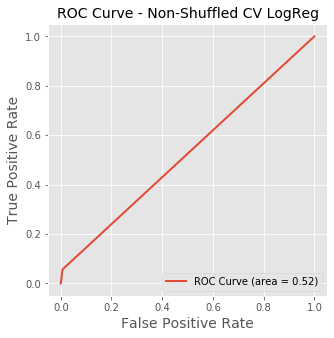

In [0]:
# Visualize results
get_classification_result(logRegClfZheng.predict(X_test), y_test, classifier_name='Non-Shuffled CV LogReg')

CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.92      0.99      0.95      7752
         Thieves       0.46      0.05      0.09       723

        accuracy                           0.91      8475
       macro avg       0.69      0.52      0.52      8475
    weighted avg       0.88      0.91      0.88      8475

CONFUSION MATRIX


,Predicted 0,Predicted 1
True 0,7708,44
True 1,685,38


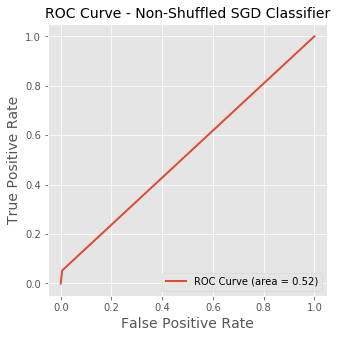

In [0]:
get_classification_result(sgdClfZheng.predict(X_test), y_test, classifier_name='Non-Shuffled SGD Classifier')

In [0]:
logRegTest = LogisticRegression()

In [0]:
coefs = np.random.rand()

AttributeError: ignored

In [0]:
logistic